In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.grid_search import GridSearchCV
plt.style.use('ggplot')

%matplotlib inline

Reading data. Defining classes.

In [141]:
data = pd.read_csv("data/initial_data.csv", header=0)

label_col = 'DriveTrain'
classes = data[label_col].unique()

## Preprocessing

Detecting type of features

In [98]:
data_label = data[label_col]
categorical_features = [col for col in data.columns if data[col].dtype.name == 'object']
categorical_features.remove(label_col)
numerical_features = [col for col in data.columns if data[col].dtype.name != 'object']

Filling N/A

In [99]:
data_processed = data.fillna(data.median(axis=0), axis=0)
data_describe = data.describe(include=[object])
for col in categorical_features:
    data_processed[col] = data_processed[col].fillna(data_describe[col]['top'])


Normalization of numerical data

In [100]:
data_numerical = data_processed[numerical_features]
data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()

for col in data_numerical:
    data_processed[col] = data_numerical[col]

Vectorization

In [101]:
binary_features    = [col for col in categorical_features if data_describe[col]['unique'] == 2]
nonbinary_features = [col for col in categorical_features if data_describe[col]['unique'] > 2]


for col in binary_features:
    top = data_describe[col]['top']
    top_items = data_processed[col] == top
    data_processed.loc[top_items, col] = 0
    data_processed.loc[np.logical_not(top_items), col] = 1    
  
    
data_not_binary = pd.get_dummies(data_processed[nonbinary_features])

for col in data_not_binary:
    data_processed[col] = data_not_binary[col]

data_processed = data_processed.drop(nonbinary_features, axis=1)

Dropping labell from dataset

In [ ]:
data_processed = data_processed.drop(label_col, axis=1)

## Feature selection

Dropping correlated features

In [106]:
features_list = ['Price', 'Luggage.room', 'RPM', 'Horsepower']
data_uncorr = data_processed[features_list]

Dimensionality reduction

In [107]:
from sklearn.decomposition import PCA
data_for_pca = data_processed
pca = PCA(n_components=2)
pca.fit(data_for_pca)
data_pca = pca.transform(data_for_pca)

Size reduction:

In [108]:
print("Number of features decreased from %d to %d after PCA." % (data_processed.shape[1], data_pca.shape[1]))

Number of features decreased from 253 to 2 after PCA.


In [120]:
data_processed = np.array(data_processed)
data_uncorr = np.array(data_uncorr)

# Building classifiers

kNN, k-Fold

In [109]:
from sklearn.neighbors import KNeighborsClassifier

X = data_pca
y = data_label

n_neighbors_array = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
best_n_neighbors_vals = []

kf = KFold(n_splits=2)
for train_index, test_index in kf.split(X):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn_clf = KNeighborsClassifier()
    grid = GridSearchCV(knn_clf, param_grid={'n_neighbors': n_neighbors_array})
    grid.fit(X_train, y_train)
    best_n_neighbors = grid.best_estimator_.n_neighbors
    best_n_neighbors_vals.append(best_n_neighbors)
    scores = cross_val_score(grid, X_test, y_test, cv=5)
print("Values of best parameters:")
print(best_n_neighbors_vals)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Values of best parameters:
[1, 9]
Accuracy: 0.68 (+/- 0.08)


kNN, stratified k-Fold

In [147]:
from sklearn.neighbors import KNeighborsClassifier

# X = data_pca
X = data_processed
# X = data_uncorr
y = data_label


n_neighbors_array = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
best_n_neighbors_vals = []

skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(X, y):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    knn_clf = KNeighborsClassifier()
    grid = GridSearchCV(knn_clf, param_grid={'n_neighbors': n_neighbors_array})
    grid.fit(X_train, y_train)
    best_n_neighbors = grid.best_estimator_.n_neighbors
    best_n_neighbors_vals.append(best_n_neighbors)
    scores = cross_val_score(knn_clf, X_test, y_test, cv=5)
print("Values of best parameters:")
print(best_n_neighbors_vals)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Values of best parameters:
[5, 1]
Accuracy: 0.72 (+/- 0.05)


Decision tree, stratified k-Fold

In [145]:
from sklearn import tree 

#X = data_pca
X = data_processed
#X = data_uncorr
y = data_label

skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(X, y):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    tree_clf = tree.DecisionTreeClassifier(max_depth=5, random_state=17)    
    tree_clf.fit(X_train, y_train)    
    scores = cross_val_score(tree_clf, X_test, y_test, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.19)


Random forest, stratified k-Fold

In [151]:
from sklearn import ensemble

#X = data_pca
X = data_processed
#X = data_uncorr
y = data_label

rf_clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)


skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(X, y):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf_clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)    
    rf_clf.fit(X_train, y_train)    
    scores = cross_val_score(rf_clf, X_test, y_test, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.76 (+/- 0.07)


Random forest, stratified k-Fold, important features

In [234]:
from sklearn import ensemble

X = np.array(data_processed)
y = data_label

rf_clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)

skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(X, y):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf_clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)    
    rf_clf.fit(X_train, y_train)    
    scores = cross_val_score(rf_clf, X_test, y_test, cv=5)
    
feature_names = data_processed.columns
    
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]


print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

(256,)
(256,)
(256,)
Feature importances:
 1. feature 'Fuel.tank.capacity' (0.0890)
 2. feature 'Weight' (0.0831)
 3. feature 'Rev.per.mile' (0.0544)
 4. feature 'MPG.highway' (0.0464)
 5. feature 'MPG.city' (0.0427)
 6. feature 'Passengers' (0.0409)
 7. feature 'Max.Price' (0.0373)
 8. feature 'Turn.circle' (0.0337)
 9. feature 'RPM  ' (0.0336)
10. feature 'Type_Van' (0.0335)
11. feature 'Horsepower' (0.0325)
12. feature 'Wheelbase' (0.0297)
13. feature 'Length' (0.0267)
14. feature 'Min.Price' (0.0266)
15. feature 'Rear.seat.room' (0.0253)
16. feature 'Price' (0.0235)
17. feature 'Luggage.room' (0.0206)
18. feature 'AirBags_Driver only' (0.0196)
19. feature 'Width' (0.0184)
20. feature 'Type_Sporty' (0.0162)
21. feature 'Make_BMW 535i' (0.0150)
22. feature 'Cylinders_8' (0.0149)
23. feature 'EngineSize' (0.0146)
24. feature 'Make_Ford Mustang' (0.0126)
25. feature 'AirBags_Driver & Passenger' (0.0113)
26. feature 'Man.trans.avail_Yes' (0.0099)
27. feature 'Manufacturer_BMW' (0.0091)


Random forest, stratified k-Fold, feature selection

In [236]:
from sklearn import ensemble

X = np.array(data_processed)
y = data_label

rf_clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)

skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(X, y):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf_clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)    
    rf_clf.fit(X_train, y_train)    
    scores = cross_val_score(rf_clf, X_test, y_test, cv=5)
    
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.74 (+/- 0.07)


Random forest, stratified k-Fold, without unsignificant features

In [256]:
from sklearn import ensemble
d_first = 20
drop_features = feature_names[indices[d_first:]]
#data_processed = data_processed.drop(drop_features, axis=1)
X = np.array(data_processed)
y = data_label

rf_clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)

skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(X, y):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf_clf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)    
    rf_clf.fit(X_train, y_train)    
    scores = cross_val_score(rf_clf, X_test, y_test, cv=5)
    
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

256
20
Accuracy: 0.71 (+/- 0.22)


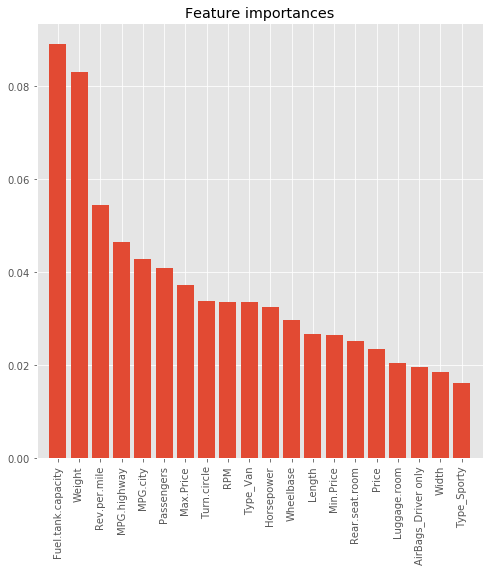

In [235]:
d_first = 20
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

GBT, stratified k-Fold

In [138]:
from sklearn import ensemble

#X = data_pca
X = data_processed
#X = data_uncorr
y = data_label


skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(X, y):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gbt_clf = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=11)
    gbt_clf.fit(X_train, y_train)
    scores = cross_val_score(gbt_clf, X_test, y_test, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.19)


Creating confussion matrix

In [152]:
from sklearn.metrics import confusion_matrix
print("GBT")
print(confusion_matrix(gbt_clf.predict(X_test), y_test))
print("Decision tree")
print(confusion_matrix(tree_clf.predict(X_test), y_test))
print("kNN tree")
print(confusion_matrix(grid.predict(X_test), y_test))
print("Random forest")
print(confusion_matrix(rf_clf.predict(X_test), y_test))

GBT
[[ 1  3  0]
 [ 4 30  8]
 [ 0  0  0]]
Decision tree
[[ 1  2  0]
 [ 4 31  7]
 [ 0  0  1]]
kNN tree
[[ 1  2  0]
 [ 3 30  5]
 [ 1  1  3]]
Random forest
[[ 0  2  0]
 [ 5 31  7]
 [ 0  0  1]]


SVM, stratified k-Fold

In [134]:
from sklearn.svm import SVC

X = data_pca
#X = data_processed
#X = data_uncorr
y = data_label

skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(X, y):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    svm_clf = SVC()
    svm_clf.fit(X_train, y_train)
    scores = cross_val_score(svm_clf, X_test, y_test, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.72 (+/- 0.05)


ELM

In [ ]:
from sklearn_extensions.extreme_learning_machines.elm import GenELMClassifier
from sklearn_extensions.extreme_learning_machines.random_layer import RBFRandomLayer, MLPRandomLayer

X = data_pca
#X = data_processed
#X = data_uncorr
y = data_label

def make_classifiers():
    names = ["ELM(10,tanh)", "ELM(10,tanh,LR)", "ELM(10,sinsq)", "ELM(10,tribas)", "ELM(hardlim)", "ELM(20,rbf(0.1))"]
    nh = 10

    sinsq = (lambda x: np.power(np.sin(x), 2.0))
    srhl_sinsq = MLPRandomLayer(n_hidden=nh, activation_func=sinsq)

    srhl_tanh = MLPRandomLayer(n_hidden=nh, activation_func='tanh')
    srhl_tribas = MLPRandomLayer(n_hidden=nh, activation_func='tribas')
    srhl_hardlim = MLPRandomLayer(n_hidden=nh, activation_func='hardlim')

    srhl_rbf = RBFRandomLayer(n_hidden=nh*2, rbf_width=0.1, random_state=0)
    log_reg = LogisticRegression()

    classifiers = [GenELMClassifier(hidden_layer=srhl_tanh),
                   GenELMClassifier(hidden_layer=srhl_tanh, regressor=log_reg),
                   GenELMClassifier(hidden_layer=srhl_sinsq),
                   GenELMClassifier(hidden_layer=srhl_tribas),
                   GenELMClassifier(hidden_layer=srhl_hardlim),
                   GenELMClassifier(hidden_layer=srhl_rbf)]

    return names, classifiers



skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(X, y):    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print('Model %s score: %s' % (name, score))
